# UCBE HW#9 
written by: Alexander Lam

In [1]:
# Dependencies
import pandas as pd
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import os
# SQL Alchemy
from sqlalchemy import func, extract
from sqlalchemy import create_engine
from sqlalchemy.orm import Session 
from sqlalchemy.ext.automap import automap_base
Base = automap_base()

In [2]:
engine = create_engine('sqlite:///hawaii.sqlite')
Base = automap_base()
Base.prepare(engine, reflect = True)
session = Session(bind=engine)

In [3]:
Base.classes.keys()

['measurement', 'station']

In [4]:
Measurement = Base.classes.measurement
Station = Base.classes.station

# Precipitation Analysis

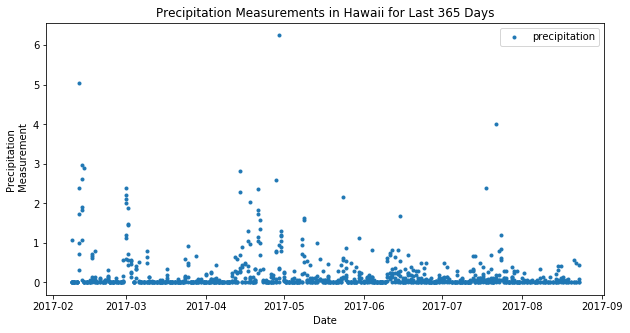

In [5]:
DAYS_IN_YEAR = 365
query_result = session.query(Measurement.date,Measurement.prcp).filter(
    Measurement.date > (date.today()-timedelta(days = DAYS_IN_YEAR))).order_by(Measurement.date).all()

dates = [entry[0] for entry in query_result]
prcp = [entry[1] for entry in query_result]
precipitation = pd.DataFrame({'date' : dates, 'prcp' : prcp})
plt.figure(figsize = [10,5])
plt.plot(precipitation['date'],precipitation['prcp'],'.',label='precipitation')
plt.title(f'Precipitation Measurements in Hawaii for Last {DAYS_IN_YEAR} Days')
plt.ylabel('Precipitation \n Measurement')
plt.legend()
plt.xlabel('Date')
plt.show()

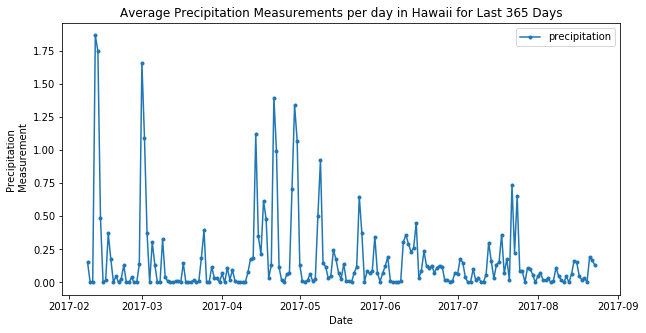

In [6]:
query_result = session.query(Measurement.date,func.avg(Measurement.prcp)).filter(
    Measurement.date > (date.today()-timedelta(days = DAYS_IN_YEAR))).group_by(
    Measurement.date).order_by(Measurement.date).all()

dates = [entry[0] for entry in query_result]
prcp = [entry[1] for entry in query_result]
precipitation = pd.DataFrame({'date' : dates, 'prcp' : prcp})
plt.figure(figsize = [10,5])
plt.plot(precipitation['date'],precipitation['prcp'],'.-',label='precipitation')
plt.title(f'Average Precipitation Measurements per day in Hawaii for Last {DAYS_IN_YEAR} Days')
plt.ylabel('Precipitation \n Measurement')
plt.legend()
plt.xlabel('Date')
plt.show()

Precipitation Statistics (averaged over all stations by date)

In [7]:
query_result = session.query(Measurement.date,Measurement.prcp).filter(
    Measurement.date > (date.today()-timedelta(days = DAYS_IN_YEAR))).order_by(Measurement.date).subquery()
prcp_df = pd.read_sql_query(query_result,engine)
prcp_df.describe()

,prcp
count,1055.000000
mean,0.180569
std,0.474318
min,0.000000
25%,0.000000
50%,0.010000
75%,0.125000
max,6.250000


In [8]:
query_result = session.query(Measurement.date,func.avg(Measurement.prcp).label('Avg_prcp')).filter(
    Measurement.date > (date.today()-timedelta(days = DAYS_IN_YEAR))).group_by(
    Measurement.date).order_by(Measurement.date).subquery()
prcp_df = pd.read_sql_query(query_result,engine)
prcp_df.describe()

,Avg_prcp
count,197.000000
mean,0.168748
std,0.311021
min,0.000000
25%,0.008333
50%,0.065000
75%,0.158333
max,1.866667


# Station Analysis

Station list by Activity

In [9]:
query_result = session.query(Measurement.station,func.count(Measurement.station)).filter(
    Measurement.date > (date.today()-timedelta(days = DAYS_IN_YEAR))).group_by(
    Measurement.station).order_by(func.count(Measurement.station).desc()).all()
counter = 1
for station in query_result:
    print('%s. %s: %s' % (counter,station[0],station[1]))
    counter += 1

1. USC00519397: 192
2. USC00519281: 183
3. USC00513117: 174
4. USC00516128: 168
5. USC00519523: 164
6. USC00514830: 141
7. USC00517948: 33


Frequency of Measurement for most active station

In [10]:
most_active = session.query(Measurement.station,func.count(Measurement.station)).filter(
    Measurement.date > (date.today()-timedelta(days = DAYS_IN_YEAR))).group_by(
    Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
most_active

'USC00519397'

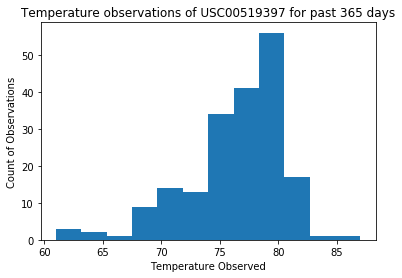

In [11]:
tobs = session.query(Measurement.tobs).filter(Measurement.station == most_active).filter(
    Measurement.date > (date.today()-timedelta(days = DAYS_IN_YEAR))).all()
# convert tuples to list
tobs = [obs[0] for obs in tobs] 
plt.hist(tobs,12)
plt.title(f'Temperature observations of {most_active} for past {DAYS_IN_YEAR} days')
plt.ylabel('Count of Observations')
plt.xlabel('Temperature Observed')
plt.show()

# Temperature Analysis

In [12]:
def calc_temps(start_date_str, end_date_str = datetime.strftime(date.today(),'%Y-%m-%d')):
#     date format: %Y-%m-%d
    start_date = datetime.strptime(start_date_str,'%Y-%m-%d')
    end_date = datetime.strptime(end_date_str,'%Y-%m-%d')
    query_result = session.query(func.min(Measurement.tobs),
                                 func.max(Measurement.tobs),
                                 func.avg(Measurement.tobs)).filter( 
                                Measurement.date.between(start_date, end_date)).all()
    return query_result

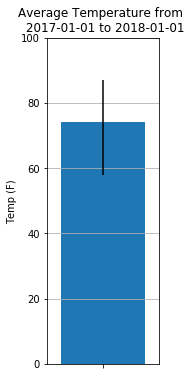

In [27]:
start = '2017-01-01'
end = '2018-01-01'
(min_t,max_t,avg_t) = calc_temps(start,end)[0]
plt.figure(figsize = [2,6])
plt.bar(0,avg_t, tick_label = '', yerr = [[avg_t - min_t],[max_t - avg_t]], width = 0.75)
plt.xlim([-0.5,0.5])
plt.ylim([0,100])
plt.ylabel('Temp (F)')
plt.grid(True, axis = 'y')
plt.title(f'Average Temperature from \n {start} to {end}')
plt.show()

# Other Analysis

In [14]:
def prcp_daily_normals(query_date_str):
#     date format: %m-%d
    query_date = datetime.strptime(query_date_str,'%m-%d')
    query_result = session.query(
        Measurement.station,
        func.min(Measurement.prcp).label('Min_Precipitation'),
        func.max(Measurement.prcp).label('Max_Precipitation'),
        func.avg(Measurement.prcp).label('Avg_Precipitation')).filter(
        extract('day', Measurement.date) == query_date.day).filter(
        extract('month', Measurement.date) == query_date.month).group_by(Measurement.station).subquery()
    output_df = pd.read_sql_query(query_result,engine)
    return output_df

In [15]:
prcp_daily_normals('01-01')

,station,Min_Precipitation,Max_Precipitation,Avg_Precipitation
0,USC00511918,0.00,0.05,0.008333
1,USC00513117,0.00,0.42,0.148750
2,USC00514830,0.00,0.14,0.028000
3,USC00516128,0.00,0.24,0.070000
4,USC00518838,0.21,0.21,0.210000
5,USC00519281,0.00,0.38,0.123750
6,USC00519397,0.00,0.08,0.012500
7,USC00519523,0.00,0.38,0.081429


In [16]:
def daily_normals(query_date_str):
#     date format: %m-%d
    query_date = datetime.strptime(query_date_str,'%m-%d')
    query_result = session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)).filter(
        extract('day', Measurement.date) == query_date.day).filter(
        extract('month', Measurement.date) == query_date.month).all()
    return query_result[0]

In [17]:
vacation_dates = ['01-01','01-02','01-03','01-04','01-05','01-06','01-07']
vacation_df = pd.DataFrame({
    'min Temp' : [],
    'avg Temp' : [],
    'max Temp' : []
})
for day in vacation_dates:
    (t_min, t_max, t_avg) = daily_normals(day)
    this_day_df = pd.DataFrame({
        'min Temp' : t_min,
        'avg Temp' : t_avg,
        'max Temp' : t_max
    },index=[day])
    vacation_df = pd.concat([vacation_df,this_day_df],axis=0)

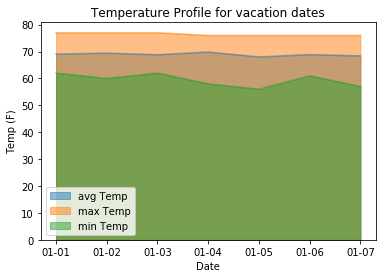

In [18]:
vacation_df.plot.area(stacked=False)
plt.title('Temperature Profile for vacation dates')
plt.xlabel('Date')
plt.ylabel('Temp (F)')
plt.show()